# YouTube Sentiment Analysis

``` yaml
original code: https://www.kaggle.com/code/stoicstatic/twitter-sentiment-analysis-for-beginners
editor: JiHo Lee
last edited: Mar. 19

note:
- youtube data feature 개수에 맞게 다시 twitter data model을 training 함
- 학습된 모델에 youtube data 긁어 온 것으로 테스트
- 테스트한 결과 manually label 필요

```

In [ ]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer
#additional nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
#additional sklearn
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Importing dataset

The dataset being used is the **sentiment140 dataset**. It contains 1,600,000 tweets extracted using the Twitter API. The tweets have been annotated **(0 = Negative, 4 = Positive)** and they can be used to detect sentiment.

*The **training data isn't perfectly categorised** as it has been created by tagging the text according to the emoji present. So, any model built using this dataset **may have lower than expected accuracy**, since the dataset isn't perfectly categorised.*

It contains the following 6 fields:

- **sentiment**: the polarity of the tweet (0 = negative, 4 = positive)
- ids The id of the tweet (2087)
- date the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- flag: The query (lyx). If there is no query, then this value is NO_QUERY.
- user: the user that tweeted (robotickilldozr)
- **text**: the text of the tweet (Lyx is cool)

We require only the **sentiment** and **text** fields, so we discard the rest.\
Furthermore, we're **changing the sentiment field** so that it has new values to reflect the sentiment. (**0 = Negative, 1 = Positive**)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive


Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
#config
data_dir = '/content/drive/MyDrive/NLP'

<ipython-input-4-10a340c3be2e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['sentiment'] = dataset['sentiment'].replace(4,1)


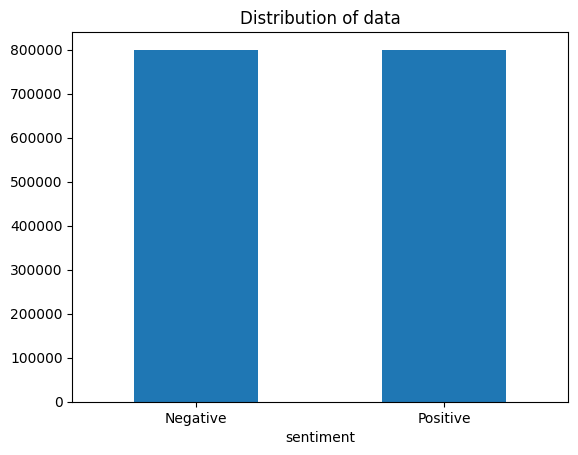

In [ ]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv(f'{data_dir}/training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data', legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

## Preprocess Text
Text Preprocessing is traditionally an important step for Natural Language Processing (NLP) tasks. It transforms text into a more digestible form so that machine learning algorithms can perform better.

The **Preprocessing steps** taken are:

- Lower Casing: Each text is converted to lowercase.
- Replacing URLs: Links starting with "http" or "https" or "www" are replaced by "URL".
- Replacing Emojis: Replace emojis by using a pre-defined dictionary containing emojis along with their meaning. (eg: ":)" to "EMOJIsmile")
- Replacing Usernames: Replace @Usernames with word "USER". (eg: "@Kaggle" to "USER")
- Removing Non-Alphabets: Replacing characters except Digits and Alphabets with a space.
- Removing Consecutive letters: 3 or more consecutive letters are replaced by 2 letters. (eg: "Heyyyy" to "Heyy")
- Removing Short Words: Words with length less than 2 are removed.
- Removing Stopwords: Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the - meaning of the sentence. (eg: "the", "he", "have")
- Lemmatizing: Lemmatization is the process of converting a word to its base form. (e.g: “Great” to “Good”)

In [ ]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']
def preprocess(textdata):
    processedText = []

    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()

    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    for tweet in textdata:
        tweet = tweet.lower()

        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')

        processedText.append(tweetwords)

    return processedText

In [ ]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 122 seconds


## <mark> BERT 작성중 <mark>

In [ ]:
# Bert 사용에 필요한 모듈 불러오기
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, Adafactor, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences

import random
import datetime

In [ ]:
# BERT gpu 사용하기
import os

n_devices = torch.cuda.device_count()
print(n_devices)

for i in range(n_devices):
    print(torch.cuda.get_device_name(i))

1
Tesla T4


In [ ]:
# BERT에 맞는 Tag 달아주기
bert_text = []
train_data = processedtext[:100000]

for i in train_data:
  bert = ["[CLS] " + str(i) + " [SEP]"]
  bert_text.append(bert)

bert_text[:5]

[['[CLS] USER URL aww that bummer you shoulda got david carr of third day to do it EMOJIwink  [SEP]'],
 ['[CLS] is upset that he can update his facebook by texting it and might cry a result school today also blah  [SEP]'],
 ['[CLS] USER dived many time for the ball managed to save 50 the rest go out of bound  [SEP]'],
 ['[CLS] my whole body feel itchy and like it on fire  [SEP]'],
 ['[CLS] USER no it not behaving at all mad why am here because can see you all over there  [SEP]']]

In [ ]:
test_data = processedtext[100000:180000]
test_text = []

for i in test_data:
  bert = ["[CLS] " + str(i) + " [SEP]"]
  test_text.append(bert)

test_text[:5]

[['[CLS] omg just moisturised and my leg are burning me it really hurt go away  [SEP]'],
 ['[CLS] USER yeah just good deadpool wa waay wrong  [SEP]'],
 ['[CLS] feel bad for danny gokey  [SEP]'],
 ['[CLS] how much blood do they need from they took even more today  [SEP]'],
 ['[CLS] USER my reply is no  [SEP]']]

In [ ]:
num = 250000
train_num = int(num*0.7)
test_num = int(num*0.3)

train_neg = int(train_num/2)
test_neg = int(test_num/2)

sentiment_train = sentiment[:train_neg]
sentiment_train.extend(sentiment[800000:800000+train_neg])

sentiment_test = sentiment[train_neg:train_neg+test_neg]
sentiment_test.extend(sentiment[800000+train_neg:800000+train_neg+test_neg])

In [ ]:
del(text)
# tokenizing 오래걸림 주의
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_data = []
for i in bert_text:
  for j in i:
    tokens = tokenizer.tokenize(j)
    tokenized_data.append(tokens)
print(tokenized_data[0:10])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

[['[CLS]', 'US', '##ER', 'URL', 'aw', '##w', 'that', 'bu', '##mmer', 'you', 'should', '##a', 'got', 'da', '##vid', 'car', '##r', 'of', 'third', 'day', 'to', 'do', 'it', 'EM', '##O', '##J', '##I', '##win', '##k', '[SEP]'], ['[CLS]', 'is', 'upset', 'that', 'he', 'can', 'update', 'his', 'face', '##book', 'by', 'text', '##ing', 'it', 'and', 'might', 'c', '##ry', 'a', 'result', 'school', 'today', 'also', 'bl', '##ah', '[SEP]'], ['[CLS]', 'US', '##ER', 'div', '##ed', 'many', 'time', 'for', 'the', 'ball', 'managed', 'to', 'save', '50', 'the', 'rest', 'go', 'out', 'of', 'bound', '[SEP]'], ['[CLS]', 'my', 'whole', 'body', 'feel', 'it', '##chy', 'and', 'like', 'it', 'on', 'fire', '[SEP]'], ['[CLS]', 'US', '##ER', 'no', 'it', 'not', 'be', '##hav', '##ing', 'at', 'all', 'ma', '##d', 'why', 'am', 'here', 'because', 'can', 'see', 'you', 'all', 'over', 'there', '[SEP]'], ['[CLS]', 'US', '##ER', 'not', 'the', 'whole', 'crew', '[SEP]'], ['[CLS]', 'need', 'hu', '##g', '[SEP]'], ['[CLS]', 'US', '##ER', '

In [ ]:
tokenized_test_data = []
for i in test_text:
  for j in i:
    tokens = tokenizer.tokenize(j)
    tokenized_test_data.append(tokens)

In [ ]:
# padding
input_ids = []
for i in tokenized_data:
  ids = tokenizer.convert_tokens_to_ids(i)
  input_ids.append(ids)

input_ids_test = []
for i in tokenized_test_data:
  ids = tokenizer.convert_tokens_to_ids(i)
  input_ids_test.append(ids)

print(input_ids[0])
print(input_ids_test[0])

max_len = 128
input_ids = pad_sequences(input_ids, maxlen=max_len, dtype='long', truncating='post', padding='post')

input_ids_test = pad_sequences(input_ids_test, maxlen=max_len, dtype='long', truncating='post', padding='post')

# masking
attention_masks = []

for ids in input_ids:
  ids_mask = []
  for id in ids:
      masked = float(id>0)
      ids_mask.append(masked)
  attention_masks.append(ids_mask)

attention_masks_test = []

for ids in input_ids_test:
  ids_mask = []
  for id in ids:
      masked = float(id>0)
      ids_mask.append(masked)
  attention_masks_test.append(ids_mask)

[101, 10808, 24093, 31191, 56237, 10874, 10189, 11499, 26944, 13028, 14819, 10113, 19556, 10143, 32194, 13000, 10129, 10108, 12628, 11940, 10114, 10149, 10271, 20569, 11403, 15417, 11281, 24748, 10174, 102]
[101, 10209, 10240, 12820, 17083, 40388, 16219, 10111, 15127, 33810, 10301, 78514, 10911, 10271, 30181, 52824, 10123, 11783, 14942, 102]


In [ ]:
# train, validation 분리

train_label = np.array(sentiment[:100000])
X_train, X_val, y_train, y_val = train_test_split(
    input_ids, train_label, random_state=42, test_size=0.2)

train_masks, validation_masks, _, _ = train_test_split(attention_masks,
                                                       input_ids,
                                                       random_state=42,
                                                       test_size=0.2)

In [ ]:
X_train.shape,  X_val.shape, y_train.shape, y_val.shape

((80000, 128), (20000, 128), (80000,), (20000,))

In [ ]:
# Fine-tuning과 Tensor로 사용할 데이터를 분리
X_train_tune = X_train
y_train_tune = y_train
X_val_tune = X_val
y_val_tune = y_val

X_test_tensor = input_ids_test
y_test_tensor = np.array(sentiment[100000:180000])
test_masks = attention_masks_test

In [ ]:
# PyTorch로 변환

X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
train_masks = torch.tensor(train_masks)
X_val_tensor = torch.tensor(X_val)
y_val_tensor = torch.tensor(y_val)
validation_masks = torch.tensor(validation_masks)

X_test_tensor = torch.tensor(X_test_tensor)
y_test_tensor = torch.tensor(y_test_tensor)
test_masks = torch.tensor(attention_masks_test)

In [ ]:
# batch size 는 8의 배수인 것이 좋
batch_size = 32

train = TensorDataset(X_train_tensor, train_masks, y_train_tensor)
train_sampler = RandomSampler(train)

val = TensorDataset(X_val_tensor, validation_masks, y_val_tensor)
val_sampler = SequentialSampler(val)


test = TensorDataset(X_test_tensor, test_masks, y_test_tensor)
test_sampler = RandomSampler(test)

train_dataloader = DataLoader(train, sampler=train_sampler, batch_size=batch_size)
val_dataloader = DataLoader(val, sampler=val_sampler, batch_size=batch_size)
test_dataloader = DataLoader(test, sampler=test_sampler, batch_size=batch_size)

In [ ]:
# GPU 사용 가능 여부
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

No GPU available, using the CPU instead.


In [ ]:
# BERT모델은 Fine-Tuning을 통해 원하는 목적에 맞게 최적화 시킬 수도 있다.
# 이번 단계에서는 모델의 최종 학습 전, 모델을 Fine-Tuning하여 성능을 올리고자 한다.
# 일단 BERT 모델을 초기화한다. Transformers의 BertForSequenceClassification 모듈을 활용한다.
#  타깃은 0과 1로 이루어져 있기 때문에, 라벨의 수는 2가 될 것이다.
# 사용할 BERT모듈의 이름은 "bert-case-multilingual-cased"라는 것으로 영어 이외의 언어 텍스트 데이터를 처리하는데 유용하다.

model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 필요한 파라미터만 Fine-Tuning을 진행할 수 있도록 requires_grad를 False로 설정한다.
for param in model.base_model.parameters():
    param.requires_grad = False

In [ ]:

train_docs, val_docs, train_labels, val_labels = train_test_split(
    train_data,
    sentiment[:100000],
    test_size=.2
)

In [ ]:
from transformers import BertTokenizerFast

model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)

train_encodings = tokenizer(train_docs, truncation=True, padding='max_length', max_length=max_len)
val_encodings = tokenizer(val_docs, truncation=True, padding='max_length', max_length=max_len)

In [ ]:
class Cord19Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Cord19Dataset(train_encodings, train_labels)
val_dataset = Cord19Dataset(val_encodings, val_labels)

In [ ]:
! pip install -U accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 823.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [ ]:
! pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 29.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2


In [ ]:
from transformers import Trainer, TrainingArguments
# 오래걸림 주
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    evaluation_strategy="epoch",     # Evaluation is done at the end of each epoch.
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=0,                # number of warmup steps for learning rate scheduler
    weight_decay=0,               # strength of weight decay
    save_total_limit=1,              # limit the total amount of checkpoints. Deletes the older checkpoints.
)


trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.003600,0.000463
2,0.002100,0.000212


TrainOutput(global_step=5000, training_loss=0.014590991592407227, metrics={'train_runtime': 1493.1207, 'train_samples_per_second': 107.158, 'train_steps_per_second': 3.349, 'total_flos': 1.05244422144e+16, 'train_loss': 0.014590991592407227, 'epoch': 2.0})

In [ ]:
# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 1e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값,
                )
# 에폭수
epochs = 3

# 총 훈련 스텝
total_steps = len(train_dataloader) * epochs

# Learning rate decay를 위한 스케줄러
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# 정확도 계산 함수
def accuracy_measure(y_pred, y):
    pred_flattened = np.argmax(y_pred, axis=1).flatten()
    y_flattened = y.flatten()
    return np.sum(pred_flattened == y_flattened) / len(y_flattened)

# 시간 표시 함수
def time_elapsed(elapsed):
    # 반올림
    elapsed = int(round((elapsed)))
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed))


In [ ]:
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

In [ ]:
# 본격적인 학습
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================


    # 현재 훈련 조건 표시
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
          elapsed = time_elapsed(time.time() - t0)
          print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)

        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행
        outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)

        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(time_elapsed(time.time() - t0)))
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in val_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)

        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # 그래디언트 계산 안함
        with torch.no_grad():
          # Forward 수행
          outputs = model(b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_input_mask)

          # 로스 구함
          logits = outputs[0]

          # CPU로 데이터 이동
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

          # 출력 로짓과 라벨을 비교하여 정확도 계산
          tmp_eval_accuracy = accuracy_measure(logits, label_ids)
          eval_accuracy += tmp_eval_accuracy
          nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(time_elapsed(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 3 ========
Training...
  Batch   500  of  2,500.    Elapsed: 0:01:57.
  Batch 1,000  of  2,500.    Elapsed: 0:03:53.
  Batch 1,500  of  2,500.    Elapsed: 0:05:48.
  Batch 2,000  of  2,500.    Elapsed: 0:07:44.

  Average training loss: 0.00
  Training epcoh took: 0:09:38

Running Validation...
  Accuracy: 1.00
  Validation took: 0:02:20

======== Epoch 2 / 3 ========
Training...
  Batch   500  of  2,500.    Elapsed: 0:01:55.
  Batch 1,000  of  2,500.    Elapsed: 0:03:50.
  Batch 1,500  of  2,500.    Elapsed: 0:05:45.
  Batch 2,000  of  2,500.    Elapsed: 0:07:40.

  Average training loss: 0.00
  Training epcoh took: 0:09:35

Running Validation...
  Accuracy: 1.00
  Validation took: 0:02:21

======== Epoch 3 / 3 ========
Training...
  Batch   500  of  2,500.    Elapsed: 0:01:55.
  Batch 1,000  of  2,500.    Elapsed: 0:03:50.
  Batch 1,500  of  2,500.    Elapsed: 0:05:45.
  Batch 2,000  of  2,500.    Elapsed: 0:07:41.

  Average training loss: 0.00
  Training epcoh t

In [ ]:

#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = time_elapsed(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)

    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch

    # 그래디언트 계산 안함
    with torch.no_grad():
        # Forward 수행
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = accuracy_measure(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(time_elapsed(time.time() - t0)))

KeyboardInterrupt: 

In [ ]:

# file = open('Sentiment-BNB-youtube.pickle-trump','wb')
# pickle.dump(model, file)
# file.close()

#odel.save("topic_model")
model.save_pretrained("bert_twitter")

# from bertopic import BERTopic
# model2 = BERTopic.load("topic_model")
# model2.visualize_barchart()

<hr>YouTube Test Code<hr>



In [ ]:
comments = pd.read_csv(f'{data_dir}/youtube_ai_comments_20240419_17_57.csv',
                      encoding=DATASET_ENCODING)
comments_colums = ["id", "unnamed: 0", "author", "published_at", "updated_at", "like_count", "text"]
text_comments = list(comments['text'])

In [ ]:
from transformers import BertForMaskedLM
model = BertForMaskedLM.from_pretrained(f'bert_twitter')


Some weights of BertForMaskedLM were not initialized from the model checkpoint at bert_twitter and are newly initialized: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TFBertModel
model = TFBertModel.from_pretrained(f'bert_twitter')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
bert_text = []
for i in text_comments:
  bert = ["[CLS] " + str(i) + " [SEP]"]
  bert_text.append(bert)
bert_text[:5]

[['[CLS] More productive? <br>Shouldn&#39;t we just much rather learn how to chill and be happy with less? [SEP]'],
 ['[CLS] This is just simple, the rich will get richer through Ai , while the poor remain poorð\x9f\x98¢ [SEP]'],
 ['[CLS] Eventually artificial intelligence will take over all human jobs. UBI Will have to be introduced. [SEP]'],
 ['[CLS] The down side of AI is that big cities like Berlin or London, which have the highest concentration of software and office workers will see a huge rise in permanent unemployment. I think these cities will soon face the Detroit syndrome. [SEP]'],
 ['[CLS] â\x9c¨ <b><i>&quot;A.I. isn&#39;t about making machines more human like, but to make humans more machine like.&quot;</i></b> â\x9c¨ [SEP]']]

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_data = []
for i in bert_text:
  for j in i:
    tokens = tokenizer.tokenize(j)
    tokenized_data.append(tokens)
print(tokenized_data[0:10])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


[['[CLS]', 'More', 'product', '##ive', '?', '<', 'br', '>', 'Should', '##n', '&', '#', '39', ';', 't', 'we', 'just', 'much', 'rather', 'learn', 'how', 'to', 'chi', '##ll', 'and', 'be', 'happy', 'with', 'less', '?', '[SEP]'], ['[CLS]', 'This', 'is', 'just', 'simple', ',', 'the', 'rich', 'will', 'get', 'riche', '##r', 'through', 'Ai', ',', 'while', 'the', 'poor', 'remain', 'poor', '##ð', '##¢', '[SEP]'], ['[CLS]', 'Eventually', 'artificial', 'intelligence', 'will', 'take', 'over', 'all', 'human', 'jobs', '.', 'UB', '##I', 'Will', 'have', 'to', 'be', 'introduced', '.', '[SEP]'], ['[CLS]', 'The', 'down', 'side', 'of', 'AI', 'is', 'that', 'big', 'cities', 'like', 'Berlin', 'or', 'London', ',', 'which', 'have', 'the', 'highest', 'concentration', 'of', 'software', 'and', 'office', 'workers', 'will', 'see', 'a', 'huge', 'rise', 'in', 'permanent', 'une', '##mployment', '.', 'I', 'think', 'these', 'cities', 'will', 'soon', 'face', 'the', 'Detroit', 'syndrome', '.', '[SEP]'], ['[CLS]', 'â', '##¨'

In [ ]:
input_ids = []
for i in tokenized_data:
  ids = tokenizer.convert_tokens_to_ids(i)
  input_ids.append(ids)

print(input_ids[0])

max_len = 128
input_ids = pad_sequences(input_ids, maxlen=max_len, dtype='long', truncating='post', padding='post')

attention_masks = []

for ids in input_ids:
  ids_mask = []
  for id in ids:
      masked = float(id>0)
      ids_mask.append(masked)
  attention_masks.append(ids_mask)


[101, 15946, 21535, 11942, 136, 133, 33989, 135, 71426, 10115, 111, 108, 11303, 132, 188, 11951, 12820, 13172, 16863, 42671, 14796, 10114, 14325, 11231, 10111, 10347, 54214, 10169, 15306, 136, 102]


In [ ]:
input_ids.shape

(1082, 128)

In [ ]:
train_label = np.array(sentiment[:1082])
X_train, X_val, y_train, y_val = train_test_split(
    input_ids, train_label, random_state=42, test_size=0.01)

train_masks, validation_masks, _, _ = train_test_split(attention_masks,
                                                       input_ids,
                                                       random_state=42,
                                                       test_size=0.01)

X_train_tune = X_train
y_train_tune = y_train
X_val_tune = X_val
y_val_tune = y_val


X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
train_masks = torch.tensor(train_masks)
X_val_tensor = torch.tensor(X_val)
y_val_tensor = torch.tensor(y_val)
validation_masks = torch.tensor(validation_masks)



In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
! pip install -U accelerate

In [ ]:
! pip install -U transformers

In [ ]:
batch_size = 1082
train = TensorDataset(X_train_tensor, train_masks, y_train_tensor)
train_sampler = RandomSampler(train)

val = TensorDataset(X_val_tensor, validation_masks, y_val_tensor)
val_sampler = SequentialSampler(val)


# test = TensorDataset(X_test_tensor, test_masks, y_test_tensor)
# test_sampler = RandomSampler(test)

train_dataloader = DataLoader(train, sampler=train_sampler, batch_size=batch_size)
val_dataloader = DataLoader(val, sampler=val_sampler, batch_size=batch_size)
# test_dataloader = DataLoader(test, sampler=test_sampler, batch_size=batch_size)

train_docs, val_docs, train_labels, val_labels = train_test_split(
    text_comments,
    sentiment[:1082],
    test_size=.01
)


In [ ]:
# train = TensorDataset(X_train_tensor)
# train_sampler = RandomSampler(train)

# train_dataloader = DataLoader(train, sampler=train_sampler, batch_size=1082)
# train_docs = text_comments
# from transformers import BertTokenizerFast
# train_docs, _, _, _ = train_test_split(text_comments, sentiment[:1082], test_size=.01)

In [ ]:
len(train_docs)

1071

In [ ]:
class Cord19Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Cord19Dataset(train_docs, sentiment[:1082])

In [ ]:
def accuracy_measure(y_pred, y):
    pred_flattened = np.argmax(y_pred, axis=1).flatten()
    y_flattened = y.flatten()
    return np.sum(pred_flattened == y_flattened) / len(y_flattened)

In [ ]:
from transformers import BertForMaskedLM
model = BertForMaskedLM.from_pretrained(f'bert_twitter')

Some weights of BertForMaskedLM were not initialized from the model checkpoint at bert_twitter and are newly initialized: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(f'bert_twitter').to(device)
model.bert.load_state_dict(model.bert.state_dict())

<All keys matched successfully>

In [ ]:

for step, batch in enumerate(train_dataloader):
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

# model.eval()

# 배치를 GPU에 넣음
batch = tuple(t.to(device) for t in batch)

# 배치에서 데이터 추출
b_input_ids, b_input_mask, b_labels = batch

# 그래디언트 계산 안함
with torch.no_grad():
  # Forward 수행
  outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

# 로스 구함
logits = outputs[0]

# CPU로 데이터 이동
logits = logits.detach().cpu().numpy()
label_ids = b_labels.to('cpu').numpy()

# # 출력 로짓과 라벨을 비교하여 정확도 계산
# tmp_eval_accuracy = accuracy_measure(logits, label_ids)
# eval_accuracy += tmp_eval_accuracy
# nb_eval_steps += 1

In [ ]:
pred_flattened = np.argmax(logits, axis=1).flatten()
pred_flattened

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
from transformers import BertTokenizerFast, TFBertModel, BertForSequenceClassification

model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained('bert_twitter')


In [ ]:
for step, batch in enumerate(train_dataloader):
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
model.eval()
# 배치를 GPU에 넣음
batch = tuple(t.to(device) for t in batch)

# 배치에서 데이터 추출
b_input_ids, b_input_mask, b_labels = batch

# 그래디언트 계산 안함
with torch.no_grad():
  # Forward 수행
  outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)
# 로스 구함
logits = outputs[0]

# CPU로 데이터 이동
logits = logits.detach().cpu().numpy()
label_ids = b_labels.to('cpu').numpy()

pred_flattened = np.argmax(logits, axis=1).flatten()
pred_flattened

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])